In [1]:
import pytorch_lightning as pl

In [2]:
from torch.utils.data import Dataset, DataLoader
from skimage.io import imread
import torch
import pandas as pd
from glob import glob

Haremos un código que nos permitirá entrenar un primer modelo con el dataset MNIST

In [27]:
class MNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img = imread(self.images[idx])
        return torch.from_numpy(img), self.labels[idx]
    

class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, path, batch_size):
        super().__init__()
        self.path = path
        self.batch_size = batch_size
    def generate_df(self, l1, l2):
        return pd.DataFrame({
            'image': l1 + l2,
            'label': [1] * len(l1) + [0] * len(l2)
        })
    def setup(self, stage = None):
        train_3 = glob(str(self.path / 'train' / '3' / '*.png'))
        train_no3 = glob(str(self.path / 'train' / 'no3' / '*.png'))
        self.train_df = self.generate_df(train_3, train_no3)
        test_3 = glob(str(self.path / 'test' / '3' / '*.png'))
        test_no3 = glob(str(self.path / 'test' / 'no3' / '*.png'))
        self.test_df = self.generate_df(test_3, test_no3)
        self.train_ds = MNISTDataset(self.train_df.image.values, self.train_df.label.values)
        self.test_ds = MNISTDataset(self.test_df.image.values, self.test_df.label.values)
    def train_dataloader(self):
        return DataLoader(self.train_ds, shuffle=True, batch_size=self.batch_size)
    def val_dataloader(self, batch_size=None, shuffle=False):
        return DataLoader(
            self.test_ds,
            batch_size=self.batch_size if batch_size is None else batch_size,
            shuffle=shuffle,
            #num_workers=7,
            #persistent_workers=True,
        )

In [28]:
from pathlib import Path

path = Path('dataset')

dm = MNISTDataModule(path, batch_size=25)
dm.setup()

imgs, labels = next(iter(dm.train_dataloader()))

imgs.shape, imgs.dtype, imgs.max(), imgs.min(), labels.shape

(torch.Size([25, 28, 28]),
 torch.uint8,
 tensor(255, dtype=torch.uint8),
 tensor(0, dtype=torch.uint8),
 torch.Size([25]))

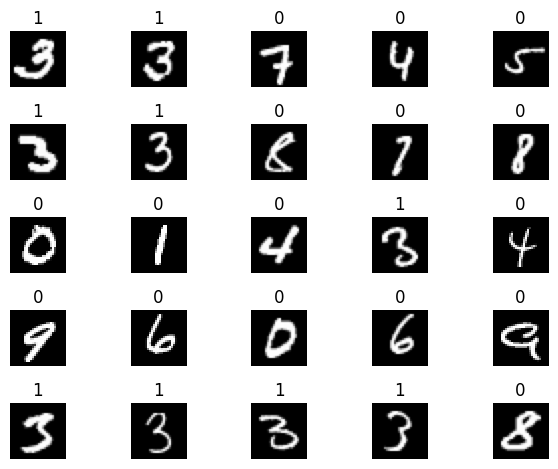

In [29]:
import matplotlib.pyplot as plt

r, c = 5, 5
fig, axs = plt.subplots(r, c)
imgs, labels = next(iter(dm.train_dataloader()))
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(imgs[i * c + j], cmap='gray')
        axs[i, j].set_title(labels[i * c + j].item())
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()

In [30]:
import torch.nn as nn
import torch.nn.functional as F


class MNISTModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(28 * 28, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    def forward(self, x):
        x = x.float() / 255
        return self.mlp(x.view(x.size(0), -1)).squeeze(-1)

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            return torch.sigmoid(self(x))

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y.float())
        preds = torch.sigmoid(y_hat) > 0.5
        acc = (preds.long() == y).float().mean()
        self.log('acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y.float())
        preds = torch.sigmoid(y_hat) > 0.5
        acc = (preds.long() == y).float().mean()
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

In [31]:
module = MNISTModule()
module

MNISTModule(
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [32]:
output = module(imgs)
output.shape

torch.Size([25])

In [33]:
dm = MNISTDataModule(path, batch_size=25)
module = MNISTModule()
trainer = pl.Trainer(
    max_epochs=10,
    logger=None,
    enable_checkpointing=False,
    #overfit_batches=1
)
trainer.fit(module, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | mlp  | Sequential | 78.6 K
------------------------------------
78.6 K    Trainable params
0         Non-trainable params
78.6 K    Total params
0.314     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\robme\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\robme\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\robme\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:293: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


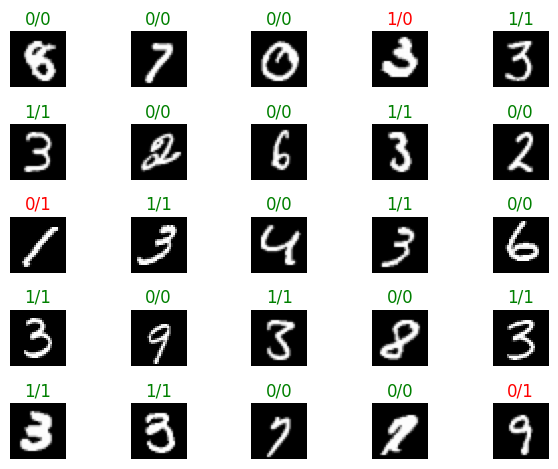

In [34]:
r, c = 5, 5
fig, axs = plt.subplots(r, c)
imgs, labels = next(iter(dm.val_dataloader(25, True)))
preds = module.predict(imgs) > 0.5
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(imgs[i * c + j], cmap='gray')
        label = labels[i * c + j].item()
        pred = preds[i * c + j].long().item()
        axs[i, j].set_title(f'{label}/{pred}', color = 'green' if label == pred else 'red')
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()